In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

num_classes = 10
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

In [6]:
history = model.fit(x_train, y_train_cat, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop, reduce_lr], verbose=2)

Epoch 1/100
625/625 - 31s - 49ms/step - accuracy: 0.3164 - loss: 3.2403 - val_accuracy: 0.3624 - val_loss: 2.7443 - learning_rate: 1.0000e-04
Epoch 2/100
625/625 - 28s - 45ms/step - accuracy: 0.4385 - loss: 2.6068 - val_accuracy: 0.4118 - val_loss: 2.8488 - learning_rate: 1.0000e-04
Epoch 3/100
625/625 - 12s - 19ms/step - accuracy: 0.5127 - loss: 2.3104 - val_accuracy: 0.5283 - val_loss: 2.3329 - learning_rate: 1.0000e-04
Epoch 4/100
625/625 - 21s - 33ms/step - accuracy: 0.5625 - loss: 2.0945 - val_accuracy: 0.5622 - val_loss: 2.1127 - learning_rate: 1.0000e-04
Epoch 5/100
625/625 - 13s - 20ms/step - accuracy: 0.6020 - loss: 1.9215 - val_accuracy: 0.5890 - val_loss: 1.9775 - learning_rate: 1.0000e-04
Epoch 6/100
625/625 - 12s - 20ms/step - accuracy: 0.6370 - loss: 1.7703 - val_accuracy: 0.6506 - val_loss: 1.7412 - learning_rate: 1.0000e-04
Epoch 7/100
625/625 - 12s - 20ms/step - accuracy: 0.6664 - loss: 1.6363 - val_accuracy: 0.6552 - val_loss: 1.6505 - learning_rate: 1.0000e-04
Epoch 

In [7]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8653 - loss: 0.5967
Test Accuracy: 0.8643, Test Loss: 0.6078


In [8]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1000
           1       0.94      0.92      0.93      1000
           2       0.86      0.78      0.82      1000
           3       0.77      0.68      0.72      1000
           4       0.81      0.89      0.85      1000
           5       0.78      0.80      0.79      1000
           6       0.85      0.94      0.89      1000
           7       0.92      0.89      0.90      1000
           8       0.92      0.94      0.93      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



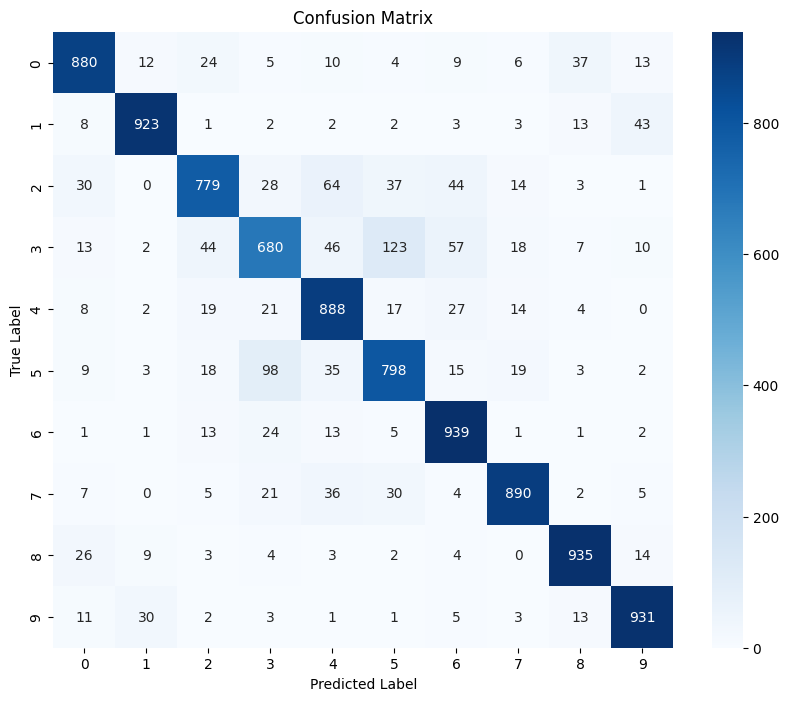

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
mse = np.mean((y_pred - y_test)**2)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.1028


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
autoencoder.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0263 - val_loss: 0.0082
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/st

In [13]:
reconstructed_images = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [14]:
ssim_scores = []
psnr_scores = []

print("Computing SSIM and PSNR for reconstructed images...")
for i in range(100):  # Sample first 100 images
    original = x_test[i]
    reconstructed = reconstructed_images[i]
    ssim_scores.append(ssim(original, reconstructed, data_range=1.0, channel_axis=2))
    psnr_scores.append(psnr(original, reconstructed, data_range=1.0))

print("Average SSIM (Reconstruction):", np.mean(ssim_scores))
print("Average PSNR (Reconstruction):", np.mean(psnr_scores))

Computing SSIM and PSNR for reconstructed images...
Average SSIM (Reconstruction): 0.8278693674302047
Average PSNR (Reconstruction): 24.554111457603508


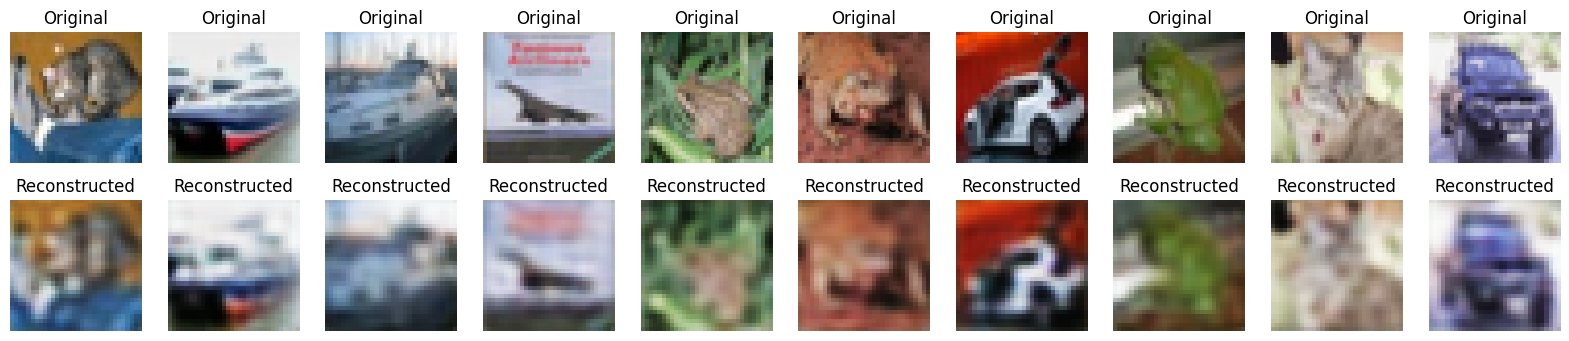

In [15]:
import matplotlib.pyplot as plt

n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()